# Sample Demo

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pyhecdss

## Setting message level and program name


In [2]:
pyhecdss.set_message_level(10) # highest level with debug level of output
pyhecdss.set_message_level(0) # quiets messages to only aborts
pyhecdss.set_program_name('PYTHON') # name used when writing to DSS files
fname=r'sample.dss'
print('Version of DSS file ',fname,': ',pyhecdss.get_version(fname)) # version of DSS file format as a string and integer tuple

Version of DSS file  sample.dss :  ['6-VE', 6]


## Example of writing a DSS File

This notebook is an example of how to interact with the features of pyhecdss
pyhecdss is a C-Python interface to HECLIB and in particular HECDSS. The plan is to only support reading regular and irregular time series into pandas DataFrame structure.

## Opening and closing a DSS File

<font color=red>__Warning__ This will create an empty DSS file if one does not exist!</font>

Use the with statement as it takes care of closing the file handle and other resources

In [3]:
fname=r'sample.dss'
with pyhecdss.DSSFile(fname) as d:
    d.close()

## A regular time series

Create a pandas DataFrame of a sin wave and then write it out a pathname.

The concepts of regular time series is defined in HEC-DSS documentation. I would direct you there. There a limited number of period intervals supported by HEC-DSS formats. 

In addition to the pathname concept (pathnames consist of 6 parts A-F represented in a path like format /A/B/C/D/E/F/) the DSS format also stores units and the type of period (instantaneous or period and value or average as INST-VAL, PER-AVG, PER-VAL). 


In [4]:
sina=np.sin(np.linspace(-np.pi, np.pi, 201))
dfr=pd.DataFrame(sina,index=pd.date_range('01jan1990 0100',periods=len(sina),freq='15T'))

In [5]:
with pyhecdss.DSSFile(fname) as d:
    d.write_rts('/SAMPLE/SIN/WAVE//15MIN/SAMPLE1/',dfr,'UNIT-X','INST-VAL')

## An irregular time series

Create a pandas DataFrame and write it out as a pathname

Again very similar to the regular time series. For details on the concepts please refer to documentation for HEC-DSS


In [6]:
dfi=pd.DataFrame([1.5, 3.2, 2.7], index=pd.to_datetime(['01jan1990 0317', '09apr1991 0520', '05sep1992 2349']))

In [7]:
with pyhecdss.DSSFile(fname) as d:
    d.write_its('/SAMPLE/ITS1/RANDOM//IR-YEAR/SAMPLE2/',dfi,'YYY','INST-VAL')

In [8]:
# Catalog reading
with pyhecdss.DSSFile(fname) as d:
    catdf=d.read_catalog()
    display(catdf)

T       A     B       C        F        E                      D
0  T4  SAMPLE  ITS1  RANDOM  SAMPLE2  IR-YEAR  01JAN1990 - 01JAN1992
1  T4  SAMPLE   SIN    WAVE  SAMPLE1    15MIN  01JAN1990 - 01JAN1990

## Catalog filtering
The catalog dataframe from the read_catalog method can use the pandas DataFrame filtering/indexing features to create a filtered data frame. That can be then used with get_pathnames to return the filtered list of pathnames

In [9]:
fdf1=catdf[(catdf.B=='ITS1') & (catdf.C=='RANDOM')]
display(fdf1)
fdf2=catdf[catdf.B=='SIN']
display(fdf2.head())


T       A     B       C        F        E                      D
0  T4  SAMPLE  ITS1  RANDOM  SAMPLE2  IR-YEAR  01JAN1990 - 01JAN1992

T       A    B     C        F      E                      D
1  T4  SAMPLE  SIN  WAVE  SAMPLE1  15MIN  01JAN1990 - 01JAN1990

## Reading Timeseries Data


In [10]:
with pyhecdss.DSSFile(fname) as d:
    plist1=d.get_pathnames(fdf1)
    dfr1,units1,ptype1=d.read_its(plist1[0])
    display(units1,ptype1)
    display(dfr1.head())
    plist2=d.get_pathnames(fdf2)
    dfi1,units2,ptype2=d.read_rts(plist2[0])
    display(dfi1.head())

'YYY'

'INST-VAL'

/SAMPLE/ITS1/RANDOM/01JAN1990 - 01JAN1992/IR-YEAR/SAMPLE2/
1990-01-01 03:17:00                                                1.5         
1991-04-09 05:20:00                                                3.2         
1992-09-05 23:49:00                                                2.7

/SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00                                      -1.224647e-16    
1990-01-01 01:15:00                                      -3.141076e-02    
1990-01-01 01:30:00                                      -6.279052e-02    
1990-01-01 01:45:00                                      -9.410831e-02    
1990-01-01 02:00:00                                      -1.253332e-01

## Closing DSS File
Closing the DSS File is important as multi user access is possible but might hang if the other thread is writing and holding on to an open handle

<font color=red>__Warning__ Just use the "with" statement. Much better than opening and close like this!</font>

In [11]:
d=pyhecdss.DSSFile(fname)
d.close()

# Best way to work with DSS Files
Using context managers allows 

In [12]:
with pyhecdss.DSSFile('sample.dss') as d:
    display(d.read_catalog())
# d is closed once out of the context of the with statement above

T       A     B       C        F        E                      D
0  T4  SAMPLE  ITS1  RANDOM  SAMPLE2  IR-YEAR  01JAN1990 - 01JAN1992
1  T4  SAMPLE   SIN    WAVE  SAMPLE1    15MIN  01JAN1990 - 01JAN1990

In [13]:
for data in pyhecdss.get_ts('sample.dss','/SAMPLE/SIN/////'):
    print(data)

DSSDate(data=                     /SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00                                      -1.224647e-16    
1990-01-01 01:15:00                                      -3.141076e-02    
1990-01-01 01:30:00                                      -6.279052e-02    
1990-01-01 01:45:00                                      -9.410831e-02    
1990-01-01 02:00:00                                      -1.253332e-01    
...                                                                ...    
1990-01-03 02:00:00                                       1.253332e-01    
1990-01-03 02:15:00                                       9.410831e-02    
1990-01-03 02:30:00                                       6.279052e-02    
1990-01-03 02:45:00                                       3.141076e-02    
1990-01-03 03:00:00                                       1.224647e-16    

[201 rows x 1 columns], units='UNIT-X', period_type='INST-VAL')


In [14]:
for data in pyhecdss.get_matching_ts('sample.dss','//.*/////'):
    print(data)

DSSDate(data=                     /SAMPLE/ITS1/RANDOM/01JAN1990 - 01JAN1992/IR-YEAR/SAMPLE2/
1990-01-01 03:17:00                                                1.5         
1991-04-09 05:20:00                                                3.2         
1992-09-05 23:49:00                                                2.7         , units='YYY', period_type='INST-VAL')
DSSDate(data=                     /SAMPLE/SIN/WAVE/01JAN1990 - 01JAN1990/15MIN/SAMPLE1/
1990-01-01 01:00:00                                      -1.224647e-16    
1990-01-01 01:15:00                                      -3.141076e-02    
1990-01-01 01:30:00                                      -6.279052e-02    
1990-01-01 01:45:00                                      -9.410831e-02    
1990-01-01 02:00:00                                      -1.253332e-01    
...                                                                ...    
1990-01-03 02:00:00                                       1.253332e-01    
1990-01-03 02:15

## Plotting and other features
Once the data is available as a pandas DataFrame, all the features such as plotting and analysis is available through that library.

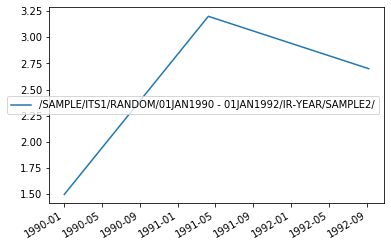

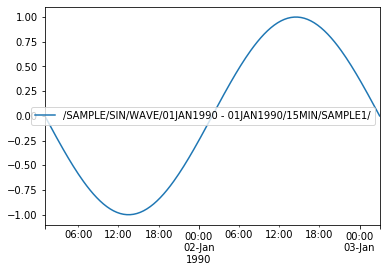

In [15]:
axes1=dfr1.plot()
axes2=dfi1.plot()